# 1. The LASSO and Boosting for Regression
(a)(b) Prepare training and test sets and deal with missing values.
(c) Plot correlation matrix for the features.

Attribute Information: 
122 predictive attributes; 
5 non-predictive attributes (first 5 columns): state, county, community, communityname, fold; 
1 goal (the last column): ViolentCrimesPerPop

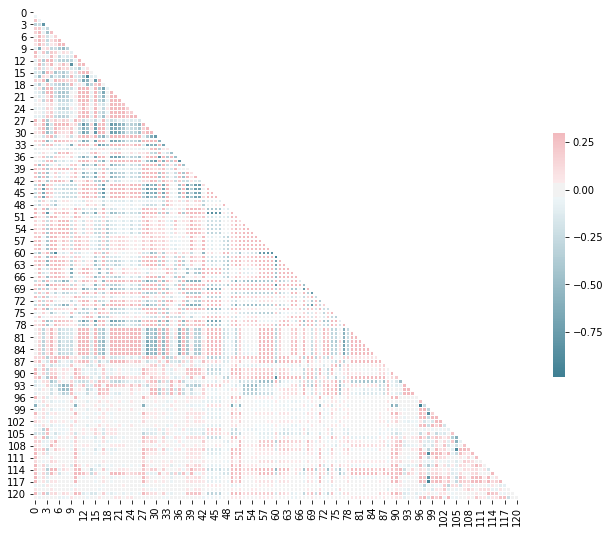

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
import seaborn as sns

df =  pd.read_csv('communities.csv', header = None)
df = df.iloc[:,5:]
df.columns = range(df.shape[1])

# mark missing values as NaN
df = df.replace('?', np.NaN)
# fill missing values with mean column values
df = pd.DataFrame(Imputer(missing_values=np.NaN, strategy='mean', axis=0).fit_transform(df.values))

train_data = df.iloc[0:1495,:]
test_data = df.iloc[1495:,:]
train_features = train_data.iloc[:,:-1]
test_features = test_data.iloc[:,:-1]
train_label = train_data.iloc[:,-1]
test_label = test_data.iloc[:,-1]

df_features =df.iloc[:,:-1]
corr = df_features.corr()
corr

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# (d)(e)

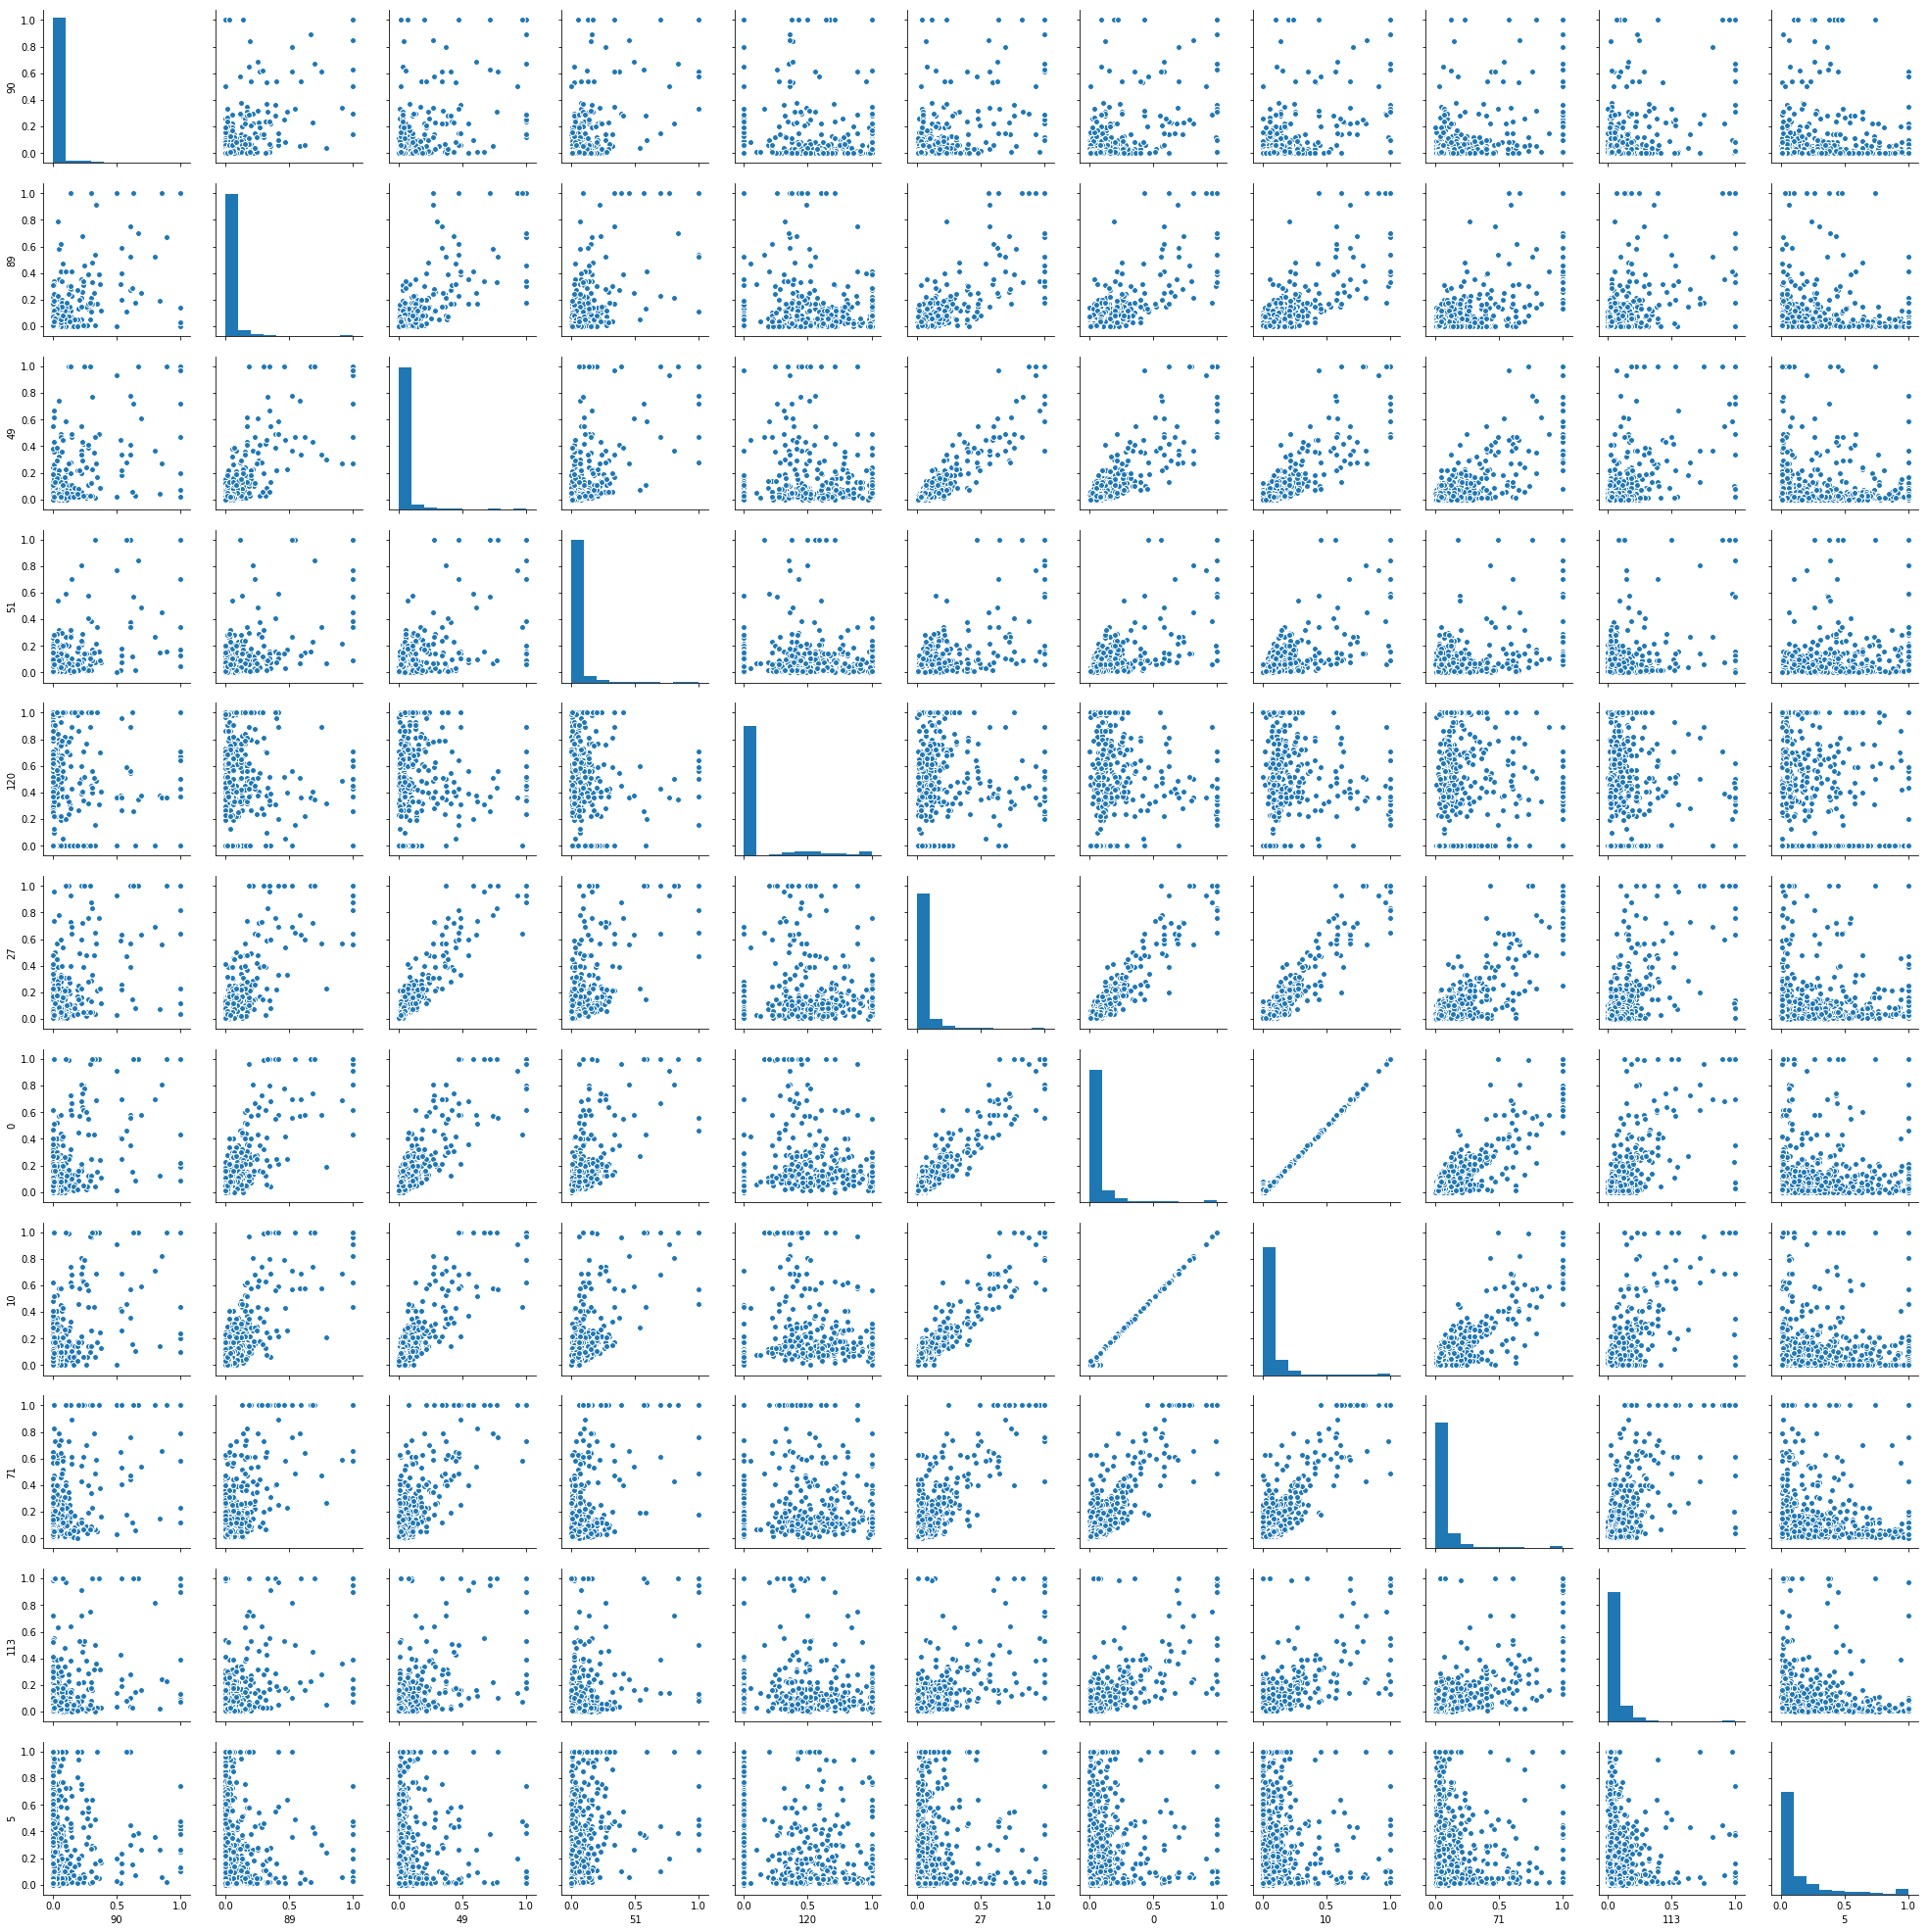

In [2]:
mean=df_features.mean(axis=0).to_frame()
std = df_features.std(axis=0).to_frame()
cv = std / mean
n = int(np.sqrt(128))
ncv = cv.nlargest(n, 0)
selected_features = df_features.iloc[:,ncv.index]

# scatter plots
sns.pairplot(selected_features)

## Just by looking at the scatterplots, we can see that not all of these selected features are significant. Most of them have non-linear relationship between each other. Only 0th and 10th features are of linear relationship.

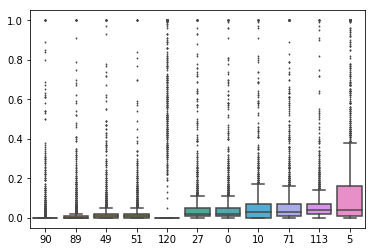

In [3]:
#box plots
sns.boxplot(data=selected_features, orient="v", fliersize=1)

# (f)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg = LinearRegression().fit(train_features, train_label)
print('The test error of linear model is', mean_squared_error(test_label, reg.predict(test_features)))

The test error of linear model is 0.7897255274211636


In [5]:
from sklearn.linear_model import RidgeCV
rig = RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5).fit(train_features, train_label)
print('The lamda selected is',rig.alpha_)
print('The test error of ridge regression model is', mean_squared_error(test_label, rig.predict(test_features)))

The lamda selected is 1.0
The test error of ridge regression model is 0.017737081104303706


In [6]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
las = LassoCV(cv=5, alphas=[0.001, 0.01, 0.1, 1.0, 10.0]).fit(train_features, train_label)
print('The lamda selected is',las.alpha_)
sfm= SelectFromModel(las)
sfm.fit(train_features, train_label)
n_features = sfm.get_support()
selected_features = df_features.columns[n_features]
print('There are %d variables selected by the model' % sum(sfm.get_support()))
print(selected_features)

print('The test error of LASSO regression model is', mean_squared_error(test_label, las.predict(test_features)))

The lamda selected is 0.001
There are 23 variables selected by the model
Int64Index([  2,   3,   7,  11,  17,  24,  38,  44,  45,  48,  50,  59,  68,
             71,  72,  74,  86,  88,  90,  91,  94, 119, 120],
           dtype='int64')
The test error of LASSO regression model is 0.017545287811568618


# (i)

In [7]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
cv_test_err = []
cv_avg_err = []

m_range = range(1, 123)
for m in m_range:
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(train_features):
        regp = PCA(n_components=m).fit(train_features.iloc[train_index,:])
        x_reg=regp.transform(train_features.iloc[train_index,:])
        y_reg=regp.transform(train_features.iloc[test_index,:])
        reg = LinearRegression().fit(x_reg, train_label.iloc[train_index])
        test_err = mean_squared_error(train_label.iloc[test_index], reg.predict(y_reg))
        cv_test_err.append(test_err)
    cv_avg_err.append(cal_avg(cv_test_err))
min_cv_err = min(cv_avg_err)
best_m = m_range[cv_avg_err.index(min_cv_err)]
print('The best number of principle components chosen by cross-validation is %d' % best_m)

x_reg = PCA(n_components=best_m).fit_transform(train_features)
reg = LinearRegression().fit(x_reg, train_label)
y_reg = PCA(n_components=best_m).fit_transform(test_features)
y_pred = reg.predict(y_reg)
print('The test error of PCR model is', mean_squared_error(test_label, y_pred))

The best number of principle components chosen by cross-validation is 116
The test error of PCR model is 0.02928421317442569


# (j) Boosting Tree

In [20]:
import xgboost as xgb
alphas = [0.001, 0.01, 0.1, 1, 10]
cv_test_err = []
cv_avg_err = []
for alpha in alphas:
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(train_features):
        clf = xgb.XGBRegressor(reg_alpha=alpha)
        clf.fit(train_features.iloc[train_index,:], train_label.iloc[train_index])
        test_err = mean_squared_error(train_label.iloc[test_index], clf.predict(train_features.iloc[test_index,:]))
        cv_test_err.append(test_err)
    cv_avg_err.append(cal_avg(cv_test_err))
min_cv_err = min(cv_avg_err)
best_alpha = alphas[cv_avg_err.index(min_cv_err)]
print('The best alpha chosen by cross-validation is %.3f' % best_alpha)

The best alpha chosen by cross-validation is 1.000
